# Neural Network

## Table of content

- [Experiment on how imbalance affect the performance](#experiment-on-how-imbalance-affect-the-performance)
    - [Without handling imbalance](#Without-handling-imbalance)
    - [Using class weights](#Using-class-weights)
    - [Using oversampling ](#Using-oversampling )
    - [Results of the experiment](#Results-of-the-experiment)
- [Find the best model](#Find-the-best-model)

In [2]:
from Functions import get_result, plot_precision_recall_vs_threshold, plot_roc_curve
from keras import Sequential, models, utils, backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.layers import Dense, Dropout, BatchNormalization
from keras.losses import BinaryCrossentropy
from keras.metrics import BinaryAccuracy, Precision, Recall, AUC, Metric
from keras.optimizers import Adam
from keras.regularizers import l2
from sklearn.utils import class_weight
import datetime
import keras_tuner as kt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

Load the datasets for training (remember they are scaled)

In [2]:
filenames = ['X_train.pkl', 'Y_train.pkl', 'X_val.pkl', 'Y_val.pkl', 'X_test.pkl', 'Y_test.pkl']
data_folder = '../data/'
dataframes = [pd.read_pickle(data_folder + filename) for filename in filenames]
X_train, Y_train, X_val, Y_val, X_test, Y_test = dataframes

Since Tensorflow do not have a built-in metric for F1 score, we'll create one. Thus can we monitor the f1 score through the training.

In [3]:
class CustomF1Score(Metric):
   def __init__(self, name='custom_f1', **kwargs):
      super().__init__(name=name, **kwargs)
      # Initialize metric state variables
      self.true_positives = self.add_weight(name='tp', initializer='zeros')
      self.false_positives = self.add_weight(name='fp', initializer='zeros')
      self.false_negatives = self.add_weight(name='fn', initializer='zeros')

   def update_state(self, y_true, y_pred, sample_weight=None):
      y_pred = K.cast(y_pred > 0.5, 'float32')  # Convert probabilities to binary predictions
      y_true = K.cast(y_true, 'float32')        # Ensure labels are float32
   
      # Calculate and accumulate metrics:
      self.true_positives.assign_add(K.sum(y_true * y_pred)) 
      self.false_positives.assign_add(K.sum((1 - y_true) * y_pred)) 
      self.false_negatives.assign_add(K.sum(y_true * (1 - y_pred))) 

   def result(self):
      precision = self.true_positives / (self.true_positives + self.false_positives + K.epsilon())
      recall = self.true_positives / (self.true_positives + self.false_negatives + K.epsilon())
      return 2 * precision * recall / (precision + recall + K.epsilon())

   def reset_state(self):
      # Reset all accumulators to zero at the start of each epoch
      self.true_positives.assign(0)
      self.false_positives.assign(0)
      self.false_negatives.assign(0)

We will start by creating a function to produce some plots of the models performance and loss on the training and validation set. These will help us check for overfitting.

In [4]:
def plot_training_metrics(history):
    metrics = [
        'loss', 
        'Recall', 
        'Precision', 
        'F1'
    ]
    plt.figure(figsize=(12, 8))

    for i, metric in enumerate(metrics):
        plt.subplot(2, 2, i+1)
        plt.plot(history.epoch, history.history[metric], label='Train')
        plt.plot(history.epoch, history.history['val_' + metric], label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(metric)
        plt.legend()

    plt.tight_layout()
    plt.show()

In [5]:
BATCH_SIZE = 2048

Now, lets do an experiment of how our neural network would do, when we do not handle the imbalance in our dataset. Afterwards we'll try two different techniques to handle the imbalance.

## Experiment on how imbalance affect the performance
We'll create a function to create a simple model, which we can use for this experiment.

In [56]:
def get_simple_model():
    model = Sequential()
    model.add(Dense(64, input_shape=(X_train.shape[1],)))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(),
                    loss=BinaryCrossentropy(from_logits=False),
                    metrics=[
                        BinaryAccuracy(name='Accuracy'),
                        Precision(name='Precision'), 
                        Recall(name='Recall'), 
                        CustomF1Score(name='F1')
                    ])

    return model

### Without handling imbalance

In [58]:
model = get_simple_model()

In [59]:
history_unhandled = model.fit(
    X_train,
    Y_train,
    epochs=20,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, Y_val)
)

Epoch 1/20
134/134 [==============================] - 2s 10ms/step - loss: 0.0304 - Accuracy: 0.9973 - Precision: 0.0028 - Recall: 0.0026 - F1: 0.0027 - val_loss: 0.0098 - val_Accuracy: 0.9988 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00
Epoch 2/20
134/134 [==============================] - 1s 8ms/step - loss: 0.0106 - Accuracy: 0.9986 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - val_loss: 0.0095 - val_Accuracy: 0.9988 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00
Epoch 3/20
134/134 [==============================] - 1s 8ms/step - loss: 0.0105 - Accuracy: 0.9986 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - val_loss: 0.0095 - val_Accuracy: 0.9988 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00
Epoch 4/20
134/134 [==============================] - 1s 8ms/step - loss: 0.0103 - Accuracy: 0.9986 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - val_loss: 0.0

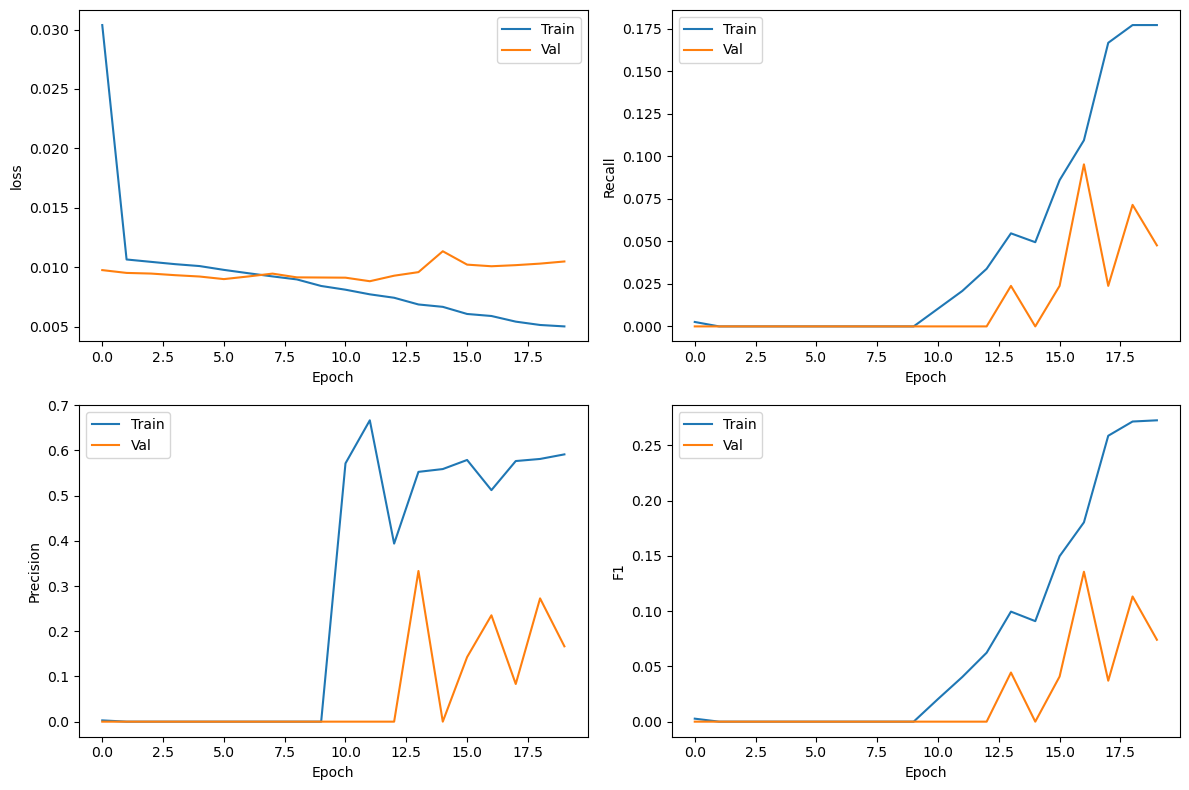

In [60]:
plot_training_metrics(history_unhandled)

In [61]:
train_predictions = model.predict(X_train, batch_size=BATCH_SIZE)
test_predictions = model.predict(X_test, batch_size=BATCH_SIZE)

17/17 [==============================] - 0s 2ms/step


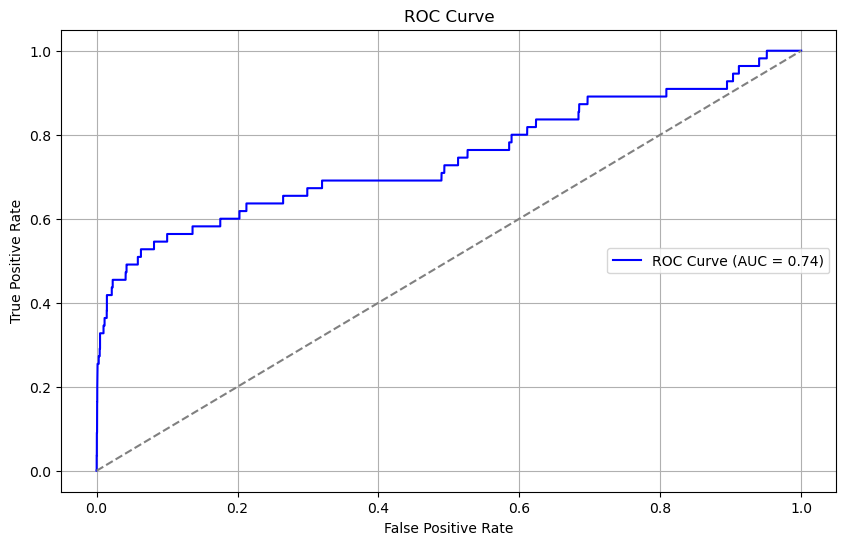

0.7447617319270678

In [62]:
plot_roc_curve(Y_test, test_predictions)

/home/ykh/Repos/CreditCardApproval/Algorithms/Functions.py:64: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


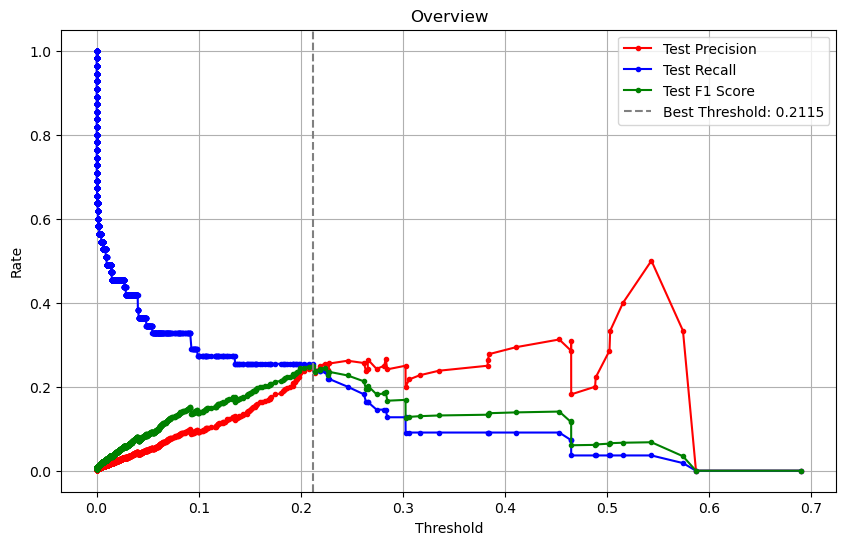

In [63]:
best_threshold = plot_precision_recall_vs_threshold('Test', Y_test, test_predictions)

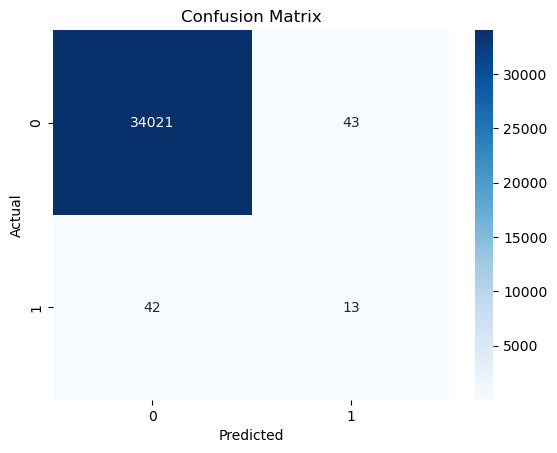

Recall       = 0.24
Precision    = 0.23
F1           = 0.23


In [64]:
_ = get_result(Y_test, test_predictions, best_threshold)

### Using class weights

In [32]:
# Calculate class weights to handle imbalance
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(Y_train), y=Y_train)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}
class_weights_dict

{0: 0.5007044320516584, 1: 355.3958333333333}

In [66]:
model = get_simple_model()

history_class_weights = model.fit(
    X_train,
    Y_train,
    class_weight=class_weights_dict,
    epochs=20,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, Y_val)
)

Epoch 1/20
134/134 [==============================] - 2s 10ms/step - loss: 0.6892 - Accuracy: 0.5624 - Precision: 0.0016 - Recall: 0.5130 - F1: 0.0033 - val_loss: 0.8011 - val_Accuracy: 0.1136 - val_Precision: 0.0013 - val_Recall: 0.9048 - val_F1: 0.0025
Epoch 2/20
134/134 [==============================] - 1s 8ms/step - loss: 0.6599 - Accuracy: 0.5976 - Precision: 0.0021 - Recall: 0.6042 - F1: 0.0042 - val_loss: 0.6155 - val_Accuracy: 0.6475 - val_Precision: 0.0020 - val_Recall: 0.5714 - val_F1: 0.0040
Epoch 3/20
134/134 [==============================] - 1s 8ms/step - loss: 0.6292 - Accuracy: 0.6279 - Precision: 0.0024 - Recall: 0.6458 - F1: 0.0049 - val_loss: 0.5653 - val_Accuracy: 0.7690 - val_Precision: 0.0022 - val_Recall: 0.4048 - val_F1: 0.0043
Epoch 4/20
134/134 [==============================] - 1s 8ms/step - loss: 0.5820 - Accuracy: 0.7052 - Precision: 0.0032 - Recall: 0.6641 - F1: 0.0063 - val_loss: 0.5300 - val_Accuracy: 0.7545 - val_Precision: 0.0031 - val_Recall: 0.6190 

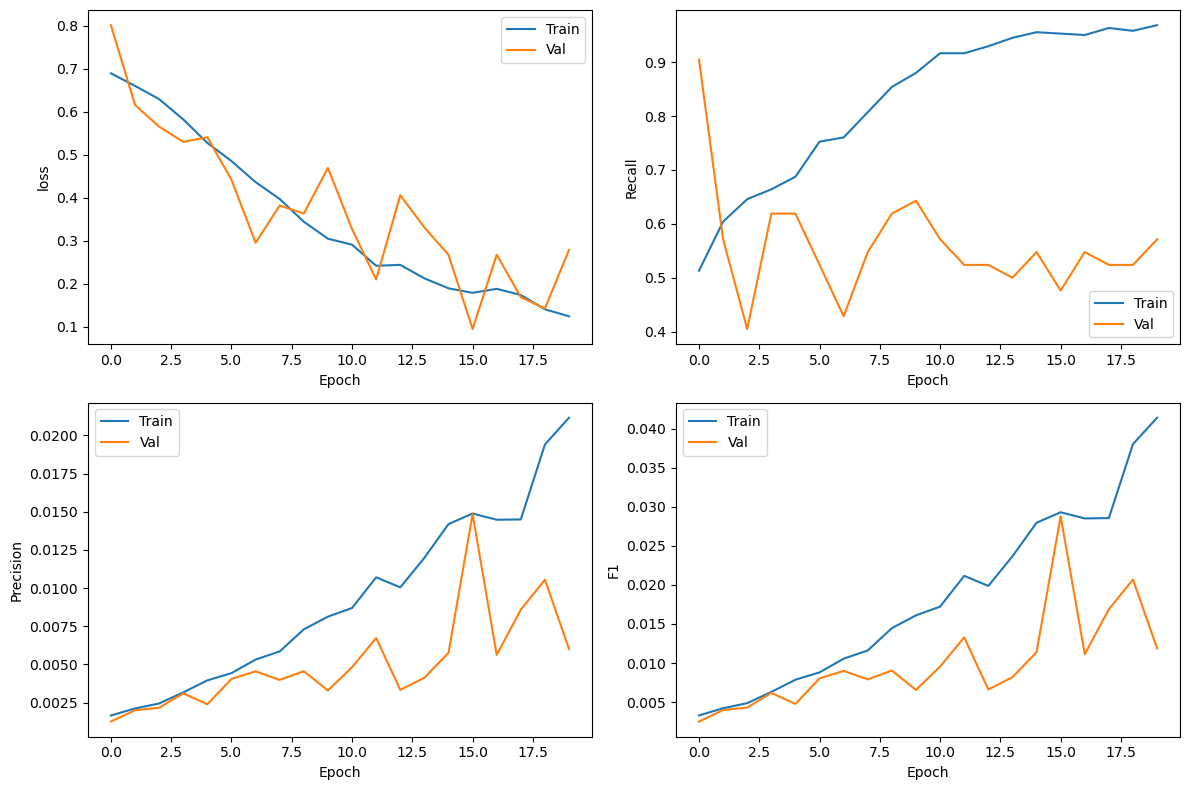

In [67]:
plot_training_metrics(history_class_weights)

In [68]:
train_predictions = model.predict(X_train, batch_size=BATCH_SIZE)
test_predictions = model.predict(X_test, batch_size=BATCH_SIZE)

17/17 [==============================] - 0s 2ms/step


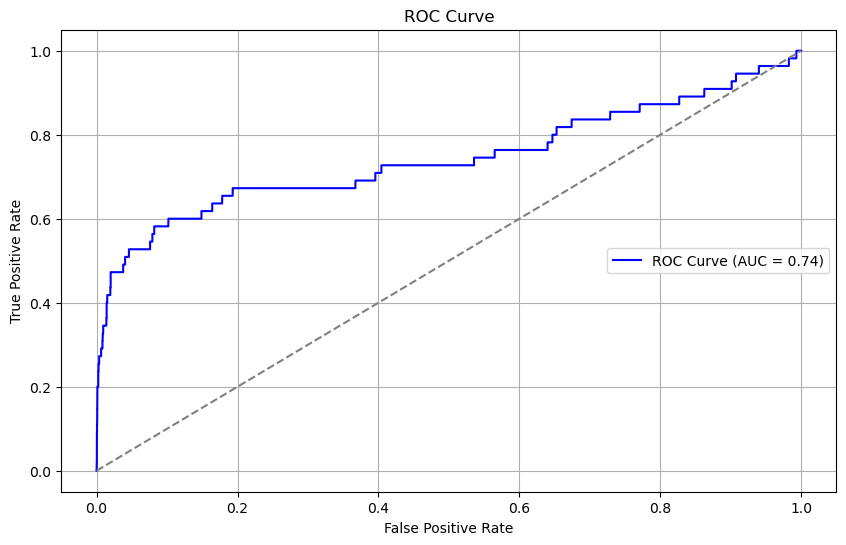

0.7434935308937188

In [69]:
plot_roc_curve(Y_test, test_predictions)

/home/ykh/Repos/CreditCardApproval/Algorithms/Functions.py:64: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


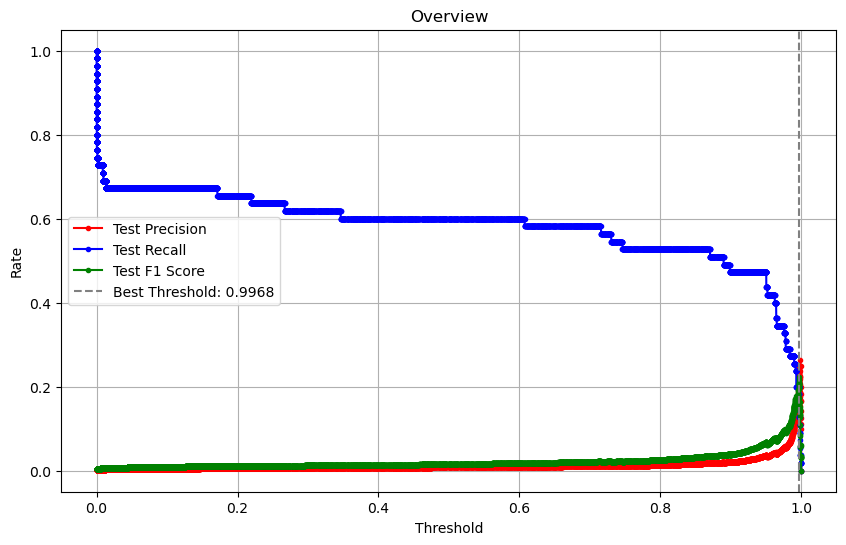

In [70]:
best_threshold = plot_precision_recall_vs_threshold('Test', Y_test, test_predictions)

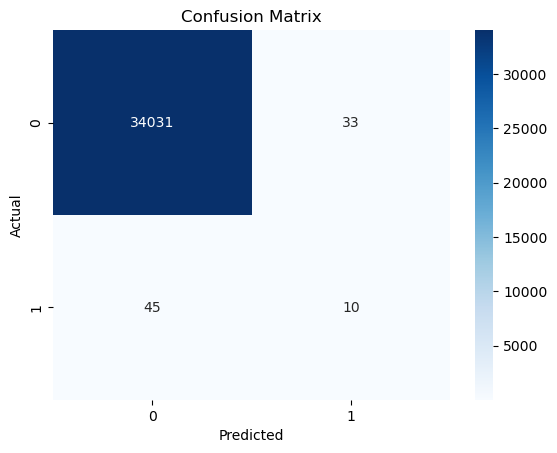

Recall       = 0.18
Precision    = 0.23
F1           = 0.2


In [71]:
_ = get_result(Y_test, test_predictions, best_threshold)

### Using oversampling 

In [6]:
# Get the IDs of the risky customers in the training set
risk_ids = Y_train[Y_train==1].index.drop_duplicates()

# Split the training set into normal and risky
X_train_normal = X_train[~X_train.index.isin(risk_ids)]
X_train_risk = X_train[X_train.index.isin(risk_ids)]

Y_train_normal = Y_train[~Y_train.index.isin(risk_ids)]
Y_train_risk = Y_train[Y_train.index.isin(risk_ids)]

print(f'Number of normal customers :', len(Y_train_normal))
print(f'Number of risky customers :', len(Y_train_risk))

Number of normal customers : 272560
Number of risky customers : 384


In [7]:
# Select risky customers at random until there is as many risky customers as normal customers 
choices = np.random.choice(X_train_risk.index, len(X_train_normal))

X_train_risk_oversampled = X_train_risk.loc[choices]
Y_train_risk_oversampled = Y_train_risk.loc[choices]

print(f'Number of risky customers (oversampled) :', X_train_risk_oversampled.shape)

Number of risky customers (oversampled) : (272560, 53)


In [8]:
# Merge the oversampled dataset with risky customers with the dataset containing normal customers 
X_train_oversampled = np.concatenate([X_train_normal, X_train_risk_oversampled], axis=0)
y_train_oversampled = np.concatenate([Y_train_normal, Y_train_risk_oversampled], axis=0)

# Shuffle the order of risky and normal customers
order = np.arange(len(y_train_oversampled))
np.random.shuffle(order)

X_train_oversampled = X_train_oversampled[order]
y_train_oversampled = y_train_oversampled[order]

In [75]:
model = get_simple_model()

history_oversampled = model.fit(
    X_train_oversampled,
    y_train_oversampled,
    epochs=20,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, Y_val)
)

Epoch 1/20
267/267 [==============================] - 3s 8ms/step - loss: 0.1509 - Accuracy: 0.9342 - Precision: 0.9238 - Recall: 0.9466 - F1: 0.9350 - val_loss: 0.0409 - val_Accuracy: 0.9904 - val_Precision: 0.0590 - val_Recall: 0.4524 - val_F1: 0.1044
Epoch 2/20
267/267 [==============================] - 2s 7ms/step - loss: 0.0384 - Accuracy: 0.9903 - Precision: 0.9854 - Recall: 0.9954 - F1: 0.9903 - val_loss: 0.0329 - val_Accuracy: 0.9935 - val_Precision: 0.0833 - val_Recall: 0.4286 - val_F1: 0.1395
Epoch 3/20
267/267 [==============================] - 2s 7ms/step - loss: 0.0143 - Accuracy: 0.9975 - Precision: 0.9950 - Recall: 1.0000 - F1: 0.9975 - val_loss: 0.0395 - val_Accuracy: 0.9935 - val_Precision: 0.0837 - val_Recall: 0.4286 - val_F1: 0.1401
Epoch 4/20
267/267 [==============================] - 2s 7ms/step - loss: 0.0131 - Accuracy: 0.9978 - Precision: 0.9957 - Recall: 1.0000 - F1: 0.9978 - val_loss: 0.0364 - val_Accuracy: 0.9945 - val_Precision: 0.1038 - val_Recall: 0.4524 -

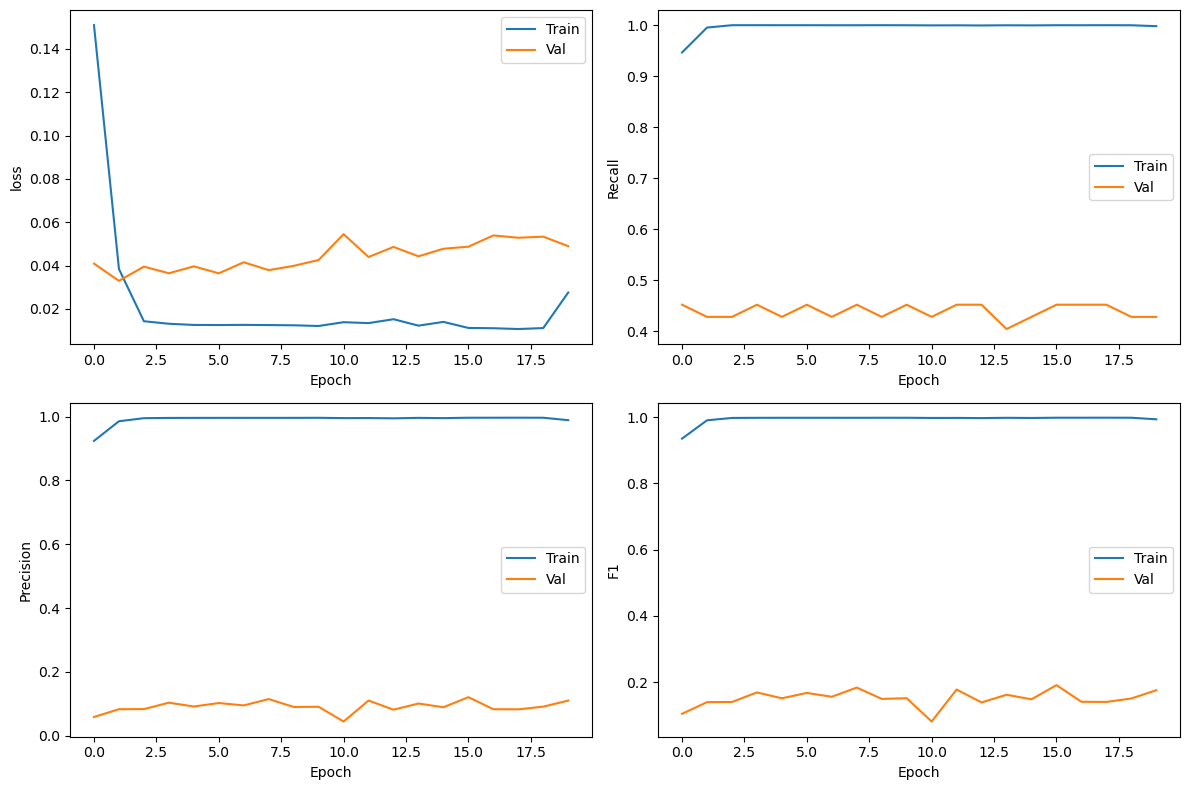

In [76]:
plot_training_metrics(history_oversampled)

In [77]:
train_predictions = model.predict(X_train, batch_size=BATCH_SIZE)
test_predictions = model.predict(X_test, batch_size=BATCH_SIZE)

17/17 [==============================] - 0s 2ms/step


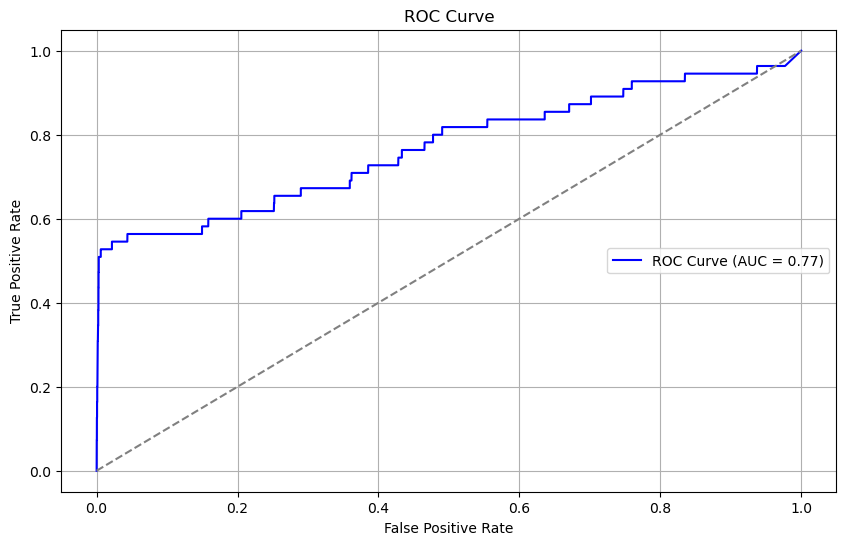

0.7702188927793672

In [78]:
plot_roc_curve(Y_test, test_predictions)

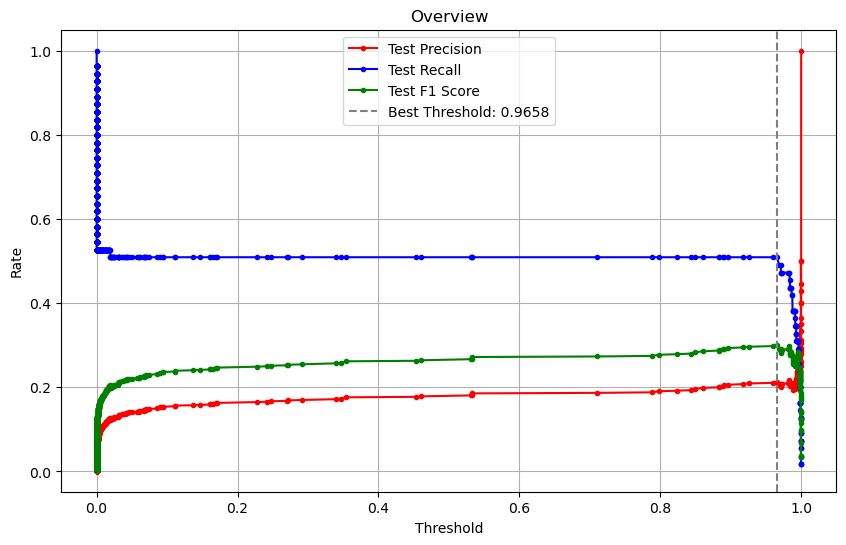

In [79]:
best_threshold = plot_precision_recall_vs_threshold('Test', Y_test, test_predictions)

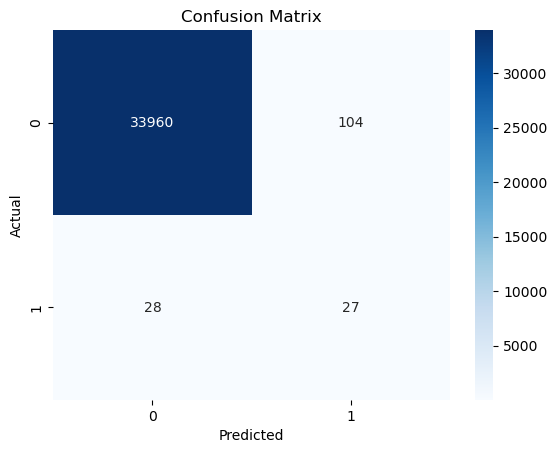

Recall       = 0.49
Precision    = 0.21
F1           = 0.29


In [81]:
_ = get_result(Y_test, test_predictions, best_threshold)

### Results of the experiment
- All the models could use some regularization (we will handle that later)
- Using nothing to handle the imbalance did okay but not good (was not the point here)
- Using class weights was the worst of the three models
    - Could be the result of too high a weight for the risky customers and too low for the normal customers, which would mean that the model focuses more on reducing errors for risky customers. However, it did not do much better on the recall anyway. Trying out different weights could improve the performance.
- Using oversampling was the the best but again not really good.

Handling imbalance is clearly an important part to create a good model. However as demonstrated, you need to test out different methods to find out what works best.

## Find the best model
Lets try to find the possible model. To do that we'll create a function that can build a model with different hyperparameters.

In [72]:
def model_builder(hp):
    """
    Build and compile a model using hyperparameters defined in Keras Tuner.

    Args:
        hp (kt.HyperParameters): Object for defining hyperparameter search space.

    Returns:
        model: A compiled Keras model.
    """

    model = Sequential()
    model.add(Dense(
        units=hp.Int("input_layer", min_value=128, max_value=1024, step=32), 
        input_shape=(X_train_oversampled.shape[1],),
        activation='relu',
        kernel_regularizer=l2(hp.Float(f"l2_0", min_value=0.0001, max_value=0.1, step=0.0005))
    ))

    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 1, 5)):
        model.add(Dense(
            # Tune the number of units
            units=hp.Int(f"units_{i+1}", min_value=128, max_value=2048, step=128),
            activation='relu',
            kernel_regularizer=l2(hp.Float(f"l2_{i}", min_value=0.0001, max_value=0.1, step=0.0005))
        ))

        # Optionally add Dropout and BatchNormalization
        if hp.Boolean(f"dropout_{i}"):
            model.add(Dropout(rate=hp.Float(f"dropout_rate_{i}", min_value=0.1, max_value=0.7, step=0.1)))
        if hp.Boolean(f"batch_norm_{i}"):
            model.add(BatchNormalization())

    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])), # Tune the leraning rate
        loss=BinaryCrossentropy(),
        metrics=[
            BinaryAccuracy(name='Accuracy'),
            Precision(name='Precision'), 
            Recall(name='Recall'), 
            CustomF1Score(name='F1')
        ])
    
    return model

In [73]:
monitor = 'val_F1'

In [75]:
model_builder(kt.HyperParameters())

tuner = kt.RandomSearch(
    hypermodel=model_builder,
    objective=kt.Objective(monitor, direction="max"),  # Objective to optimize
    max_trials=30,                                      # Number of trials to run during the search
    executions_per_trial=2,                             # Models that should be built and fit for each trial
    overwrite=True,                                     # Overwrite the previous results
    directory="Saved models",
    project_name="NN_Model_tuner",
)

tuner.search_space_summary()

Search space summary
Default search space size: 7
input_layer (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 1024, 'step': 32, 'sampling': 'linear'}
l2_0 (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.1, 'step': 0.0005, 'sampling': 'linear'}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 2048, 'step': 128, 'sampling': 'linear'}
dropout_0 (Boolean)
{'default': False, 'conditions': []}
batch_norm_0 (Boolean)
{'default': False, 'conditions': []}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


We are going to utilize a callback when running the RandomSearch:
- EarlyStopping: To stop training when the model stop to improve on the monitored metric for a number of epochs. Here we also restore the weights, which resulted in the best performence on the monitored metric.

In [76]:
# Early stopping callback for efficient training
early_stopping = EarlyStopping(
    monitor=monitor,
    patience=7,
    mode='max',
    restore_best_weights=True
)

In [77]:
tuner.search(
    X_train_oversampled,
    y_train_oversampled,
    epochs=50,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, Y_val),
    callbacks=[early_stopping]
)

Trial 30 Complete [00h 03m 04s]
val_F1: 0.1712683066725731

Best val_F1 So Far: 0.19202449917793274
Total elapsed time: 00h 47m 50s


bedste før: Best val_F1 So Far: 0.21515952050685883

In [78]:
# See the result of all the models
tuner.results_summary()

Results summary
Results in Saved models/NN_Model_tuner
Showing 10 best trials
Objective(name="val_F1", direction="max")

Trial 03 summary
Hyperparameters:
input_layer: 736
l2_0: 0.0106
num_layers: 2
units_1: 1024
dropout_0: False
batch_norm_0: True
learning_rate: 0.001
units_2: 1536
l2_1: 0.07210000000000001
dropout_1: True
batch_norm_1: True
units_3: 1408
l2_2: 0.0011
dropout_2: False
batch_norm_2: False
units_4: 256
l2_3: 0.0901
dropout_3: False
batch_norm_3: True
dropout_rate_0: 0.5
dropout_rate_1: 0.1
Score: 0.19202449917793274

Trial 27 summary
Hyperparameters:
input_layer: 288
l2_0: 0.0371
num_layers: 3
units_1: 1536
dropout_0: True
batch_norm_0: True
learning_rate: 0.0001
units_2: 768
l2_1: 0.0271
dropout_1: True
batch_norm_1: True
units_3: 384
l2_2: 0.08360000000000001
dropout_2: False
batch_norm_2: True
units_4: 768
l2_3: 0.0616
dropout_3: False
batch_norm_3: False
dropout_rate_0: 0.6
dropout_rate_1: 0.1
dropout_rate_2: 0.5
units_5: 1152
l2_4: 0.0766
dropout_4: False
batch_nor

In [79]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
for value in best_hps.values:
    print(value, ':', best_hps.values[value])  # Inspect the hyperparameter values

input_layer : 736
l2_0 : 0.0106
num_layers : 2
units_1 : 1024
dropout_0 : False
batch_norm_0 : True
learning_rate : 0.001
units_2 : 1536
l2_1 : 0.07210000000000001
dropout_1 : True
batch_norm_1 : True
units_3 : 1408
l2_2 : 0.0011
dropout_2 : False
batch_norm_2 : False
units_4 : 256
l2_3 : 0.0901
dropout_3 : False
batch_norm_3 : True
dropout_rate_0 : 0.5
dropout_rate_1 : 0.1


In [80]:
# Build the best model
best_model = tuner.hypermodel.build(best_hps)

In [81]:
best_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 736)               39744     
                                                                 
 dense_7 (Dense)             (None, 1024)              754688    
                                                                 
 batch_normalization_3 (Bat  (None, 1024)              4096      
 chNormalization)                                                
                                                                 
 dense_8 (Dense)             (None, 1536)              1574400   
                                                                 
 dropout_1 (Dropout)         (None, 1536)              0         
                                                                 
 batch_normalization_4 (Bat  (None, 1536)              6144      
 chNormalization)                                     

Before training the best model again we are going to utilize some additional callbacks:
- ModelCheckpoint: To save the best weights depending on a monitored metric.
- TensorBoard: 

In [82]:
# Model checkpoint callback for securing best weights
model_checkpoint_callback = ModelCheckpoint(
    filepath=r'Saved models/NN_best_model.keras',
    save_weights_only=False, # Save the entire model (architecture + weights)
    monitor=monitor,
    mode='max',
    save_best_only=True
)

In [83]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") # directory to store logs
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [84]:
# Train the best model and capture the training history
history_best = best_model.fit(
    X_train_oversampled,
    y_train_oversampled,
    validation_data=(X_val, Y_val),
    epochs=50, 
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping, model_checkpoint_callback, tensorboard_callback]
)

Epoch 1/50
267/267 [==============================] - 5s 14ms/step - loss: 6.7237 - Accuracy: 0.9556 - Precision: 0.9472 - Recall: 0.9650 - F1: 0.9560 - val_loss: 0.5123 - val_Accuracy: 0.9988 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00
Epoch 2/50
267/267 [==============================] - 3s 11ms/step - loss: 0.2290 - Accuracy: 0.9886 - Precision: 0.9828 - Recall: 0.9947 - F1: 0.9887 - val_loss: 0.2132 - val_Accuracy: 0.9976 - val_Precision: 0.1020 - val_Recall: 0.1190 - val_F1: 0.1099
Epoch 3/50
267/267 [==============================] - 3s 11ms/step - loss: 0.1390 - Accuracy: 0.9925 - Precision: 0.9876 - Recall: 0.9976 - F1: 0.9926 - val_loss: 0.1130 - val_Accuracy: 0.9923 - val_Precision: 0.0667 - val_Recall: 0.4048 - val_F1: 0.1145
Epoch 4/50
267/267 [==============================] - 3s 10ms/step - loss: 0.1118 - Accuracy: 0.9920 - Precision: 0.9869 - Recall: 0.9972 - F1: 0.9921 - val_loss: 0.1114 - val_Accuracy: 0.9897 - val_Precision: 0.0493 - val_

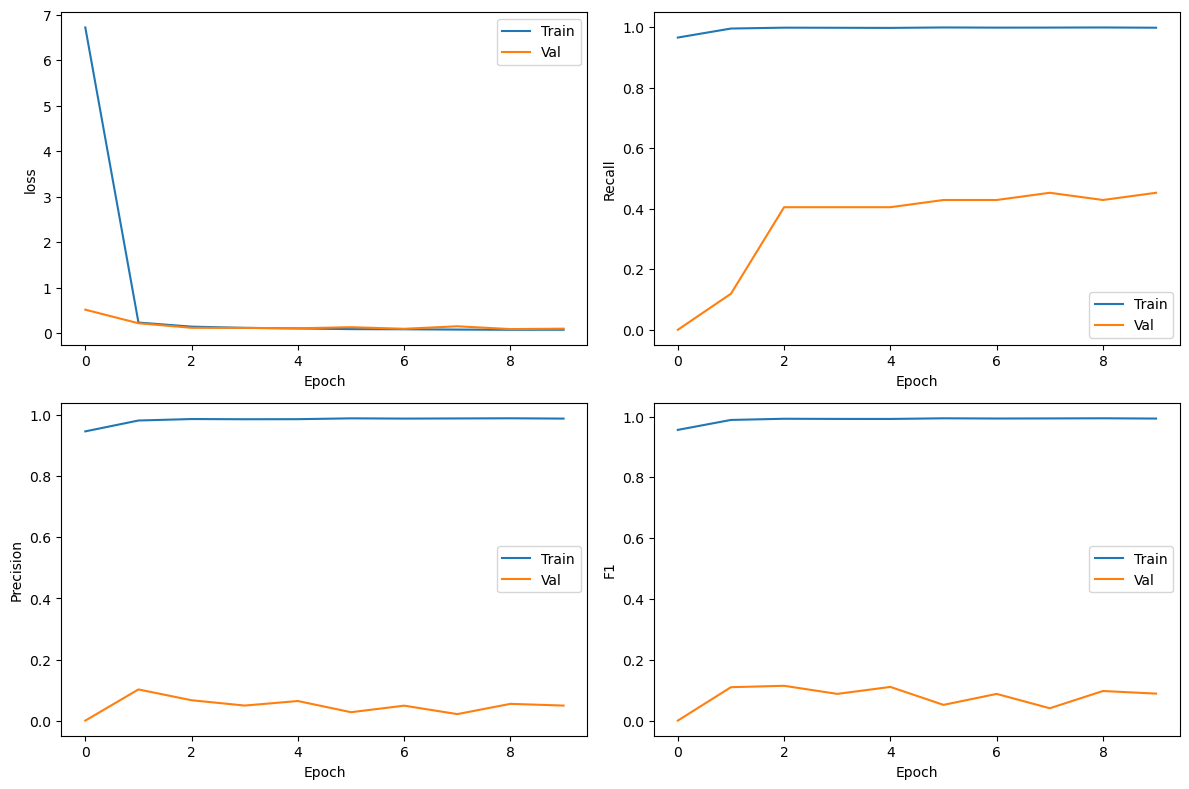

In [85]:
plot_training_metrics(history_best)

In [86]:
# Test model on test set
test_predictions = best_model.predict(X_test, batch_size=BATCH_SIZE)

17/17 [==============================] - 0s 23ms/step


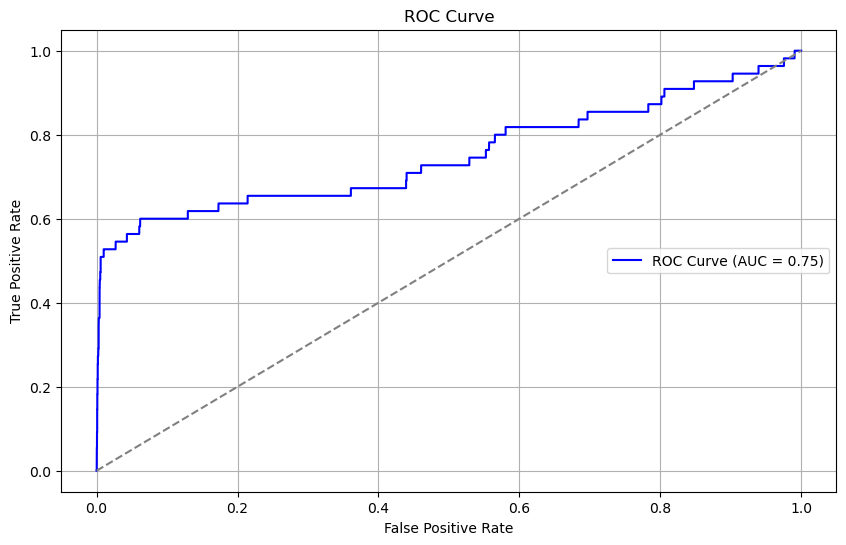

0.75098584482685

In [87]:
plot_roc_curve(Y_test, test_predictions)

/home/ykh/Repos/CreditCardApproval/Algorithms/Functions.py:64: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


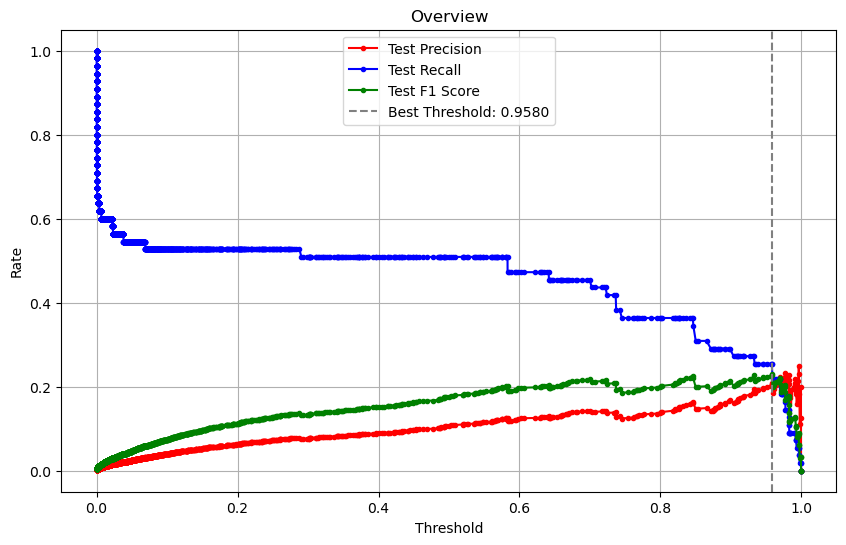

In [88]:
best_threshold = plot_precision_recall_vs_threshold('Test', Y_test, test_predictions)

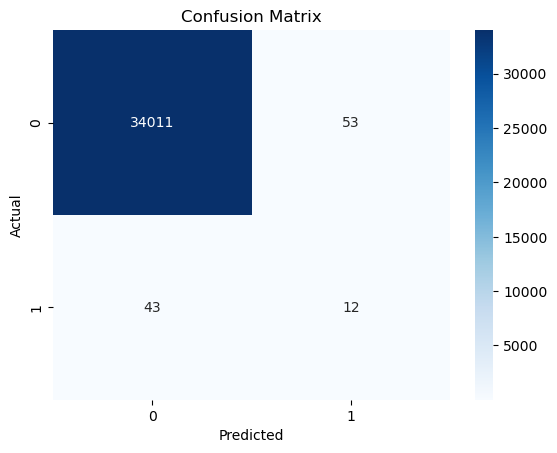

Recall       = 0.22
Precision    = 0.18
F1           = 0.2


In [89]:
_ = get_result(Y_test, test_predictions, best_threshold)